<a href="https://colab.research.google.com/github/ombarvaliya/Infosys_FakeJob_Detection_using_NLP/blob/main/01_prepare_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
dfA = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake Postings.csv")
dfB = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fake_job_postings_800fake.csv")

In [ ]:
required_columns = [
    "title", "description", "requirements", "company_profile",
    "employment_type", "industry", "benefits", "salary_range", "fraudulent"
]

dfA = dfA[required_columns]
dfB = dfB[required_columns]

In [ ]:
print("Dataset A shape:", dfA.shape)
print("Dataset B shape:", dfB.shape)

Dataset A shape: (10000, 9)
Dataset B shape: (17880, 9)


In [ ]:
dfA = dfA.fillna("")
dfB = dfB.fillna("")

In [ ]:
df_final = pd.concat([dfA, dfB], ignore_index=True)

In [ ]:
df_final.drop_duplicates(inplace=True)

In [ ]:
print("Final merged shape:", df_final.shape)
print("Fraudulent distribution:")
print(df_final['fraudulent'].value_counts())

Final merged shape: (26172, 9)
Fraudulent distribution:
fraudulent
0    15445
1    10727
Name: count, dtype: int64


In [ ]:
df_final.to_csv("merged_job_dataset.csv", index=False)
print("Merged dataset saved as merged_job_dataset.csv")

Merged dataset saved as merged_job_dataset.csv


In [ ]:
def combine_text(row):
    return " ".join([
        str(row['title']),
        str(row['description']),
        str(row['requirements']),
        str(row['company_profile']),
        str(row['employment_type']),
        str(row['industry']),
        str(row['benefits']),
        str(row['salary_range'])
    ])

df_final['text'] = df_final.apply(combine_text, axis=1)


In [ ]:
df_final[['text', 'fraudulent']].head()

,text,fraudulent
0,Mental health nurse Arm drive court sure vote....,1
1,Conference centre manager Government whom its ...,1
2,"Engineer, land I member discuss follow way the...",1
3,Forest/woodland manager House across wait appr...,1
4,"Production designer, theatre/television/film C...",1


In [ ]:
print(df_final['fraudulent'].value_counts())

fraudulent
0    15445
1    10727
Name: count, dtype: int64


In [ ]:
df_model = df_final[['text', 'fraudulent']]
df_model.to_csv("clean_job_dataset.csv", index=False)

In [ ]:
df_model.info()
df_model.describe()
df_model['fraudulent'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 26172 entries, 0 to 27878
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        26172 non-null  object
 1   fraudulent  26172 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 613.4+ KB


,count
fraudulent,
0,15445
1,10727


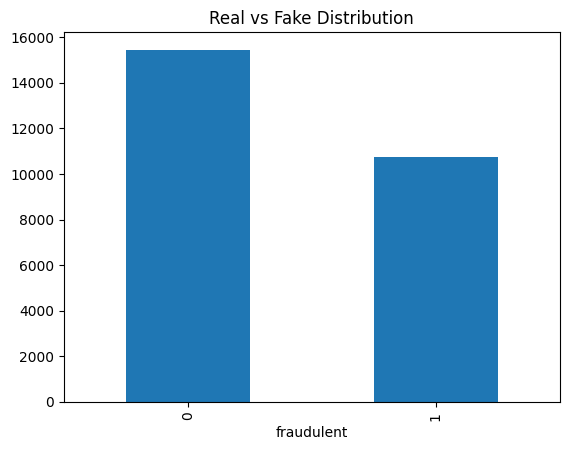

In [ ]:
import matplotlib.pyplot as plt
df_model['fraudulent'].value_counts().plot(kind='bar')
plt.title("Real vs Fake Distribution")
plt.show()

In [ ]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' urltoken ', text)   # replace links
    text = re.sub(r'\S+@\S+', ' emailtoken ', text)                 # replace emails
    text = re.sub(r'\d+', ' numbertoken ', text)                    # replace numbers
    text = re.sub(r'[^\w\s]', ' ', text)                            # remove punctuation only
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_model['clean_text'] = df_model['text'].apply(clean_text)

/tmp/ipython-input-4248732430.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['clean_text'] = df_model['text'].apply(clean_text)


In [ ]:
df_model[['text', 'clean_text', 'fraudulent']].head()

,text,clean_text,fraudulent
0,Mental health nurse Arm drive court sure vote....,mental health nurse arm drive court sure vote ...,1
1,Conference centre manager Government whom its ...,conference centre manager government whom its ...,1
2,"Engineer, land I member discuss follow way the...",engineer land i member discuss follow way ther...,1
3,Forest/woodland manager House across wait appr...,forest woodland manager house across wait appr...,1
4,"Production designer, theatre/television/film C...",production designer theatre television film ca...,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_model['clean_text'],
    df_model['fraudulent'],
    test_size=0.2,
    random_state=42,
    stratify=df_model['fraudulent']
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=2000)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9814708691499523
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3089
           1       1.00      0.95      0.98      2146

    accuracy                           0.98      5235
   macro avg       0.98      0.98      0.98      5235
weighted avg       0.98      0.98      0.98      5235

[[3089    0]
 [  97 2049]]
